In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from scipy.linalg import expm

In [2]:
N = 100; M = 20; delta_t =0.01; K = 50
T_0 = np.array([[sqrt(2)/2,0,-sqrt(2)/2,0], [0,1,0,1/2], [sqrt(2)/2,0,sqrt(2)/2,0], [0,0,0,1]])
Corr = np.diag([0.1,0.1,0.1,0.05,0.05,0.05])
D = np.concatenate((np.eye(3),np.zeros([3,1])), axis = 1)
P = np.concatenate((np.random.randn(3,M),np.ones([1,M])), axis = 0)

In [3]:
V = np.zeros([6,N])
for i in range(N):
    V[0,i] = (i + 1)/float(1 + 1*(i + 1))
    V[1,i] = (i + 1)/float(1 + 2*(i + 1))
    V[2,i] = (i + 1)/float(1 + 3*(i + 1))
    V[5,i] = (i + 1)/float((i + 1)*(i + 1)/1000.0 + (i + 1) + 1);

In [4]:
def wedge_so3(vec):
    a = vec[0]; b = vec[1]; c = vec[2];
    M = np.array([[0,-c,b], [c,0,-a], [-b,a,0]])
    return M
def wedge_se3(vec):
    vec1 = vec[0:3]; vec2 = vec[3:6]; Z = np.array([[0,0,0,0]]);
    M = np.concatenate((wedge_so3(vec2),vec1.reshape([3,1])), axis = 1)
    M = np.concatenate((M,Z), axis = 0)
    return M
def ad_se3(vec):
    vec1 = vec[0:3]; vec2 = vec[3:6]; Z = np.zeros([3,3]);
    M = np.concatenate((wedge_so3(vec2),wedge_so3(vec1)), axis = 1)
    N = np.concatenate((Z,wedge_so3(vec2)), axis = 1)
    M = np.concatenate((M,N), axis = 0)
    return M
def dot_se3(vec):
    Z = np.zeros([1,6]);
    M = np.concatenate((vec[3]*np.eye(3),-wedge_so3(vec[0:3])), axis = 1)
    M = np.concatenate((M,Z), axis = 0)
    return M

In [5]:
T_train = np.zeros([K,N + 1,12]); y_train = np.zeros([K,N + 1,60])
for k in range(K):
    T_all = np.zeros([N + 1,4,4])
    y = np.zeros([N + 1,3,M])
    T_all[0,:,:] = T_0
    T = T_0
    delta_xi = np.matmul(Corr,np.random.randn(6,1))
    for i in range(N):
        T = np.matmul(expm(delta_t*wedge_se3(V[:,i])),T)
        delta_xi = np.matmul(expm(delta_t*ad_se3(V[:,i])),delta_xi) + np.matmul(Corr,np.random.randn(6,1))
        T_all[i + 1,:,:] = np.matmul(expm(wedge_se3(delta_xi)),T)
    for i in range(N + 1):
        y[i,:,:] = np.matmul(np.matmul(D,T_all[i,:,:]),P) + 0.15*np.random.randn(3,M)
    T_trans = T_all[:,0:3,:]
    T_train[k,:,:] = T_trans.reshape([N + 1,12])
    y_train[k,:,:] = y.reshape([N + 1,60])

In [6]:
model = tf.keras.models.Sequential([
    #layers.LSTM(400, return_sequences=True),
    layers.LSTM(200, return_sequences=True),
    layers.LSTM(100, return_sequences=True),
    layers.GRU(50, return_sequences=True),
    layers.GRU(25, return_sequences=True),
    layers.SimpleRNN(12, return_sequences=True),
])

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss=tf.keras.losses.mean_squared_error,
             )

In [8]:
model.fit(y_train, T_train, epochs=200, batch_size=101)

Train on 50 samples
Epoch 1/200
50/50 [==============================] - 5s 102ms/sample - loss: 0.6016
Epoch 2/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.4421
Epoch 3/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.4075
Epoch 4/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.3494
Epoch 5/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.2953
Epoch 6/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.2711
Epoch 7/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.2523
Epoch 8/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.2121
Epoch 9/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.2062
Epoch 10/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.1906
Epoch 11/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.1714
Epoch 12/200
50/50 [==============================] - 0s 7ms/sample - loss

Epoch 100/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0420
Epoch 101/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.0418
Epoch 102/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0416
Epoch 103/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0414
Epoch 104/200
50/50 [==============================] - 0s 9ms/sample - loss: 0.0412
Epoch 105/200
50/50 [==============================] - 0s 7ms/sample - loss: 0.0410
Epoch 106/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0408
Epoch 107/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0406
Epoch 108/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0404
Epoch 109/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0402
Epoch 110/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0400
Epoch 111/200
50/50 [==============================] - 0s 8ms/sample - loss:

Epoch 198/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0313
Epoch 199/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0313
Epoch 200/200
50/50 [==============================] - 0s 8ms/sample - loss: 0.0312


In [12]:
T_all_test = np.zeros([N + 1,4,4])
y_test = np.zeros([N + 1,3,M])
T_all_test[0,:,:] = T_0
T = T_0
delta_xi = np.matmul(Corr,np.random.randn(6,1))
for i in range(N):
    T = np.matmul(expm(delta_t*wedge_se3(V[:,i])),T)
    delta_xi = np.matmul(expm(delta_t*ad_se3(V[:,i])),delta_xi) + np.matmul(Corr,np.random.randn(6,1))
    T_all_test[i + 1,:,:] = np.matmul(expm(wedge_se3(delta_xi)),T)
for i in range(N + 1):
    y_test[i,:,:] = np.matmul(np.matmul(D,T_all_test[i,:,:]),P) + 0.15*np.random.randn(3,M)
T_test = T_all_test[:,0:3,:]
T_test = T_test.reshape([N + 1,12])
y_test = y_test.reshape([N + 1,60])

In [13]:
T_pre = model.predict(y_test.reshape([1,N + 1,60]))
T_pre = T_pre[0,:,:]

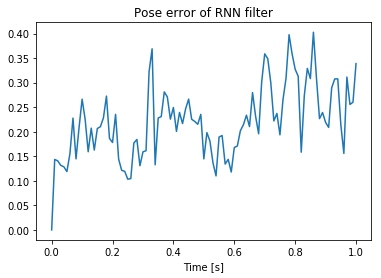

In [15]:
error = np.zeros([N + 1,1])
for i in range(N + 1):
    error[i,0] = np.linalg.norm(T_pre[i,:] - T_test[i,:], ord = np.inf)
error[0,0] = 0
time = delta_t*np.linspace(0, N, N + 1)
plt.plot(time, error)
plt.xlabel('Time [s]')
plt.title('Pose error of RNN filter')
plt.show()

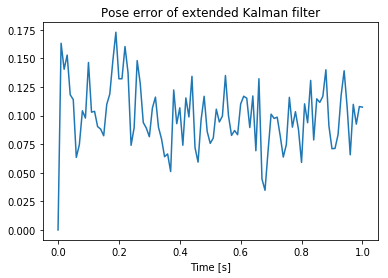

In [16]:
f = pd.read_csv('/Users/apple/Desktop/important file/Stochastic Control/Code of Final project/Kalman filter/Kalman.csv', header = None)
data = pd.DataFrame(f)
data = data.values
plt.plot(time, data)
plt.xlabel('Time [s]')
plt.title('Pose error of extended Kalman filter')
plt.show()

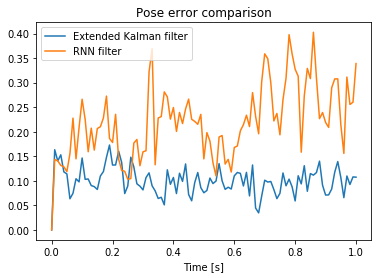

In [18]:
plt.plot(time, data, label = 'Extended Kalman filter')
plt.plot(time, error, label = 'RNN filter')
plt.xlabel('Time [s]')
plt.title('Pose error comparison')
plt.legend()
plt.show()